## Exact in distribution simulations ofr Poisson Point Process

Simulate the simplest inhomogeneous poisson point process that is non-trivial:

1. A single pre-synaptic neuron
2. Fixed time window of time ws
3. Spikes of pre-synaptic neuron spaced out every 2*ws
4. Every spikes contributes to the rate with a rectangular contribution $u(s) = 1$ if $0 < s \leq \Delta$ and 0 otherwise
    The intensity is then $l(t) = l0 + \sum_j u(t - 2 \cdot \Delta \cdot j)$
5. The cumulative intensity is $L(t) = \int_0^t l(s) ds = l_0 \cdot t + \Delta \cdot (t // (2 \cdot \Delta)) + \Delta + \text{relu}(t - \Delta \cdot (t // 20) - \Delta)$
6. The simulation follows Cinlar 1975, (the non-homogeneous process is a rescaled homogeneous one)

In [2]:
from copy import deepcopy
from functools import partial

import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from numba.np.npyfuncs import np_real_mod_impl
from scipy.integrate import simpson
from scipy.optimize import bisect
from jaxopt import ProjectedGradient, projection


def simulate_process(t_max, cumul_intensity, seed=123):
    """
    Exact simulation of inhomogeneous Poisson Point process
    by temporal re-scaling method. Cinlar 1975.
    """
    np.random.seed(seed)
    spike_times = []
    s = 0
    step_for_bisect = t_max / 100.
    t0 = 0
    upper = step_for_bisect
    while t0 < t_max:
        uni = np.random.uniform()
        s = s - np.log(uni)
        # very ugly way to be over the optimum
        # but bisect is very fast and accurate.
        while cumul_intensity(upper) < s:
            upper = upper + step_for_bisect
        spike_times.append(
            bisect(lambda x: cumul_intensity(x) - s, upper - step_for_bisect, upper, xtol=10**-14)
        )
        upper = upper - step_for_bisect
        t0 = spike_times[-1]
    spike_times = np.array(spike_times)
    return spike_times[spike_times < t_max]

# implementation of the intensity and cumulative intensity - [4, 5] above.
intensity = lambda t, l0, ws: l0 + ((t % (2 * ws)) > ws).astype(float)
cumulative_intensity = lambda t, l0, ws: l0*t + ws * (t // (2 * ws)) + jax.nn.relu(t - 2 * ws * (t // 20) - ws)



Check the cumulative intensity calculation by integrating numerically the instantaneous rate.

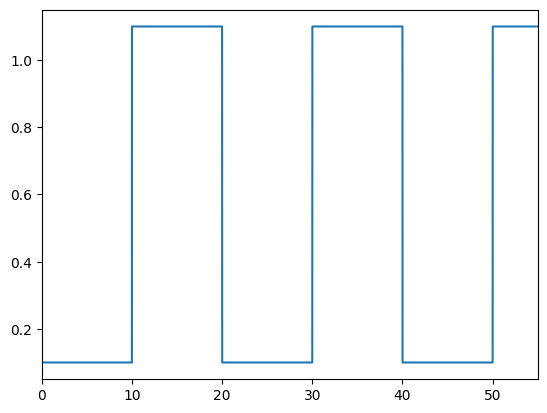

numerical check that cumulative intesity is correct: -9.1552734e-05


In [3]:
# params
l0 = 0.1 # this is l_0 in the eqn 4,5
ws = 10. # this is \Delta in the equation 4,5 (duration of the window)


n_samples = 1000000
time = np.linspace(0, 55, n_samples)


plt.plot(time, intensity(time, l0, ws))
plt.xlim(0,55)
plt.show()


approx = simpson(intensity(time, l0, ws), x=time)
true = cumulative_intensity(time[-1], l0, ws)
print("numerical check that cumulative intesity is correct:", approx - true)


## Run exact simulations

(0.0, 55.0)

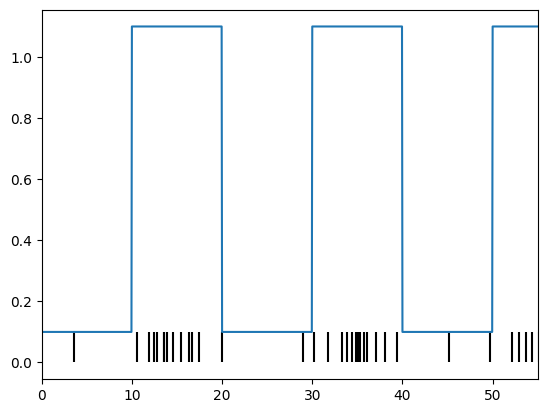

In [4]:
T = 5000

# pre-synaptic is just a metronome spiking every 2*ws
pre_synaptic = np.arange(ws, T, 2*ws).astype(float)
# simulate spikes
spike_times = simulate_process(T, lambda x: cumulative_intensity(x, l0, ws))

plt.vlines(spike_times, 0.,0.1, "k")
plt.plot(np.linspace(0, T, 10**5), intensity(np.linspace(0, T, 10**5), l0, ws))
plt.xlim(0,55)

## Fit An Exact Maximum Likelihood Estimate
Now, since we have the analytical intensity and cumulative intensity we can fit an exact ML to the Point Process with identity link, this can be used for testing implementations.

In [6]:
# jit-compilable 
parametric_intensity = lambda t, params, ws: params[0] + params[1] * jnp.asarray((t % (2 * ws)) > ws, dtype=float)
parametric_cumul = lambda t, params, ws: params[0] * t + params[1] * (ws * (t // (2 * ws)) + jax.nn.relu(t - 2 * ws * (t // 20) - ws))

jit_parametric_intensity = jax.jit(parametric_intensity)
jit_parametric_cumul = jax.jit(parametric_cumul)

@jax.jit
def neg_log_likelihood(params, window_size, post_synaptic, tmax):
    log_lam = jnp.log(jit_parametric_intensity(post_synaptic, params, window_size))
    return  jit_parametric_cumul(tmax, params, window_size) / log_lam.shape[0]  - log_lam.mean()

p0 = jnp.asarray([1, 2], dtype=float)
pg = ProjectedGradient(fun=neg_log_likelihood, projection=projection.projection_box)
pp_fit = pg.run(p0, (1E-6, jnp.inf), window_size=ws, post_synaptic=spike_times, tmax=T)

print("recovered params", pp_fit[0])


recovered params [0.0939246 0.9831332]


Compare with a regular GLM

/Users/ebalzani/Code/pynapple/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(


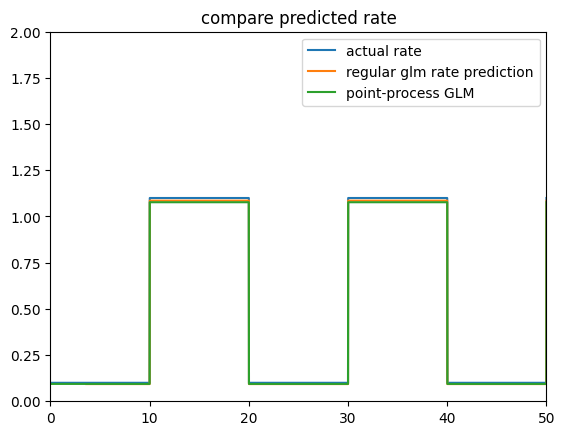

In [8]:
import pynapple as nap
import nemos as nmo
jax.config.update("jax_enable_x64", True)

bin_size = 0.001
count = nap.Ts(spike_times).count(bin_size).astype(float)
time = np.linspace(0, T, 10**6)
feature = count.value_from(nap.Tsd(time, intensity(time, l0, ws)))[:, None].astype(float)
feature = feature - feature[0,0] + 1 # make non-zero (log(feature  *w) in the poisson)

# risky, no projection available but should work on fake data
model = nmo.glm.GLM(observation_model=nmo.observation_models.PoissonObservations(lambda x:x)).fit(feature, count)
pred_rate = model.predict(feature)/bin_size
plt.figure()
plt.title("compare predicted rate")
plt.plot(time, intensity(time, l0, ws), label="actual rate")
plt.plot(pred_rate, label="regular glm rate prediction")
plt.plot(time, jit_parametric_intensity(time, pp_fit[0], ws), label="point-process GLM")
plt.xlim(0, 50)
plt.ylim(0, 2)
plt.legend()
plt.show()

## Exact GLM for Identity Link
Now we will generalize this construction to fit an exact Point Process GLM under the following assumptions:

- Identity link function.
- Non-negative basis.
- Fit using projected gradient or other constrained optimization to ensure non-negative rate. If $n$ BSplines are used then we have $n+1$ weights $\mathbf{w}$ includig the intercept. Since $\sum b_k(t) = 1$ for all $t$ in the domain of the basis, convolving the spike times with $f(t) = \begin{cases} 1 && 0\le t\le\Delta \\ 0 && \text{otherwise}\end{cases}$, and taking the max of the convolution with the spike times, i.e. $m = \max_t f(t) * \delta(t_j - t)$, than, for a positive rate it is sufficeint that: $m \cdot \sum_{i=1}^{n+1} w_i < w_0$

This construction can be easily generalized to N neurons, but let's start assuming a single pre-synaptic and post-synaptic neuron for simplicity.
Let $\Phi(t) = [b_1(t), ..., b_n(t)]$ a vector of $n$ basis fuctions such as $b_k(t) \ge 0$. All the basis have support contained in $[0, \Delta)$.

The log likelihood takes the form
$$
\mathcal{L} = \sum \log(l(t_k)) - \int_0^T \log(l(t)) \, dt = \sum \log(l(t_k)) - L(T)
$$
### Cumulative Intensity Function
If we have an identity link function and assume positive weights $\mathbf{w} \in \mathbb{R}^{n+1}$ satisfying the condition for non positve rates, for the basis plua intercept, then the intensity function is

$$
\begin{aligned}
L(t) &= \int_0^t \mathbf{w} \cdot \Phi (s) \, ds \\
     &= \mathbf{w} \cdot \left[ \sum_{\{i:\; t-t_i < \Delta\}} \int_0^\Delta \Phi (s) \, ds + \sum_{\{i:\; t - t_i \ge \Delta \}} \int_0^{\Delta - t_i} \Phi (s) \, ds \right] \\
     &= \mathbf{w} \cdot \left[N \cdot I + M \cdot \int_0^{t - t_{i_{M}}} \Phi(s) \, ds +  (M-1) \cdot \int_{t - t_{i_{M}}}^{t - t_{i_{M-1}}} \Phi(s) \, ds + ... + \int_{t - t_{i_{2}}}^{t - t_{i_{1}}} \Phi(s) \, ds\right]
\end{aligned}
$$
Here, $t-\Delta < t_{i_{1}} < t_{i_{2}} < ... < t_{i_{M}} < t$ are the sorted pre-synaptic spikes happeing in $[t-\Delta, t]$, $N= | \{ i: \; t-t_i < \Delta\} |$, $I =  \int_0^\Delta \Phi (s) \, ds$.


Note that for the likelihood we only need $L(T)$ where $T$ is the duration of the experiment, so we can compute quickly and easily all the integrals above as long as we know how to inegrate exactly $\Phi (s)$. If, for example, we use BSplines, we can compute the integral anaytically from the recursion or simply use the simpson method evaluated on the BSpline knots to get an exact integral. 

Once we have that, we can compute exactly what is in the squared parenthesis of the equaiton above and store the $n$ dimensional vector. Note that if we have multiple pre-synaptic neuron nothing change, except that we will have a matrix of weights instead of a single vector. Computing the normalization constant is now simply a dot product.

### Intensity Calculation
For the intensity the `scan`-based code we have should do the job just fine, but the idea here would be, for every post-synaptic spikes, pre-compute all the delta with pre-synaptic spikes that follows within a window, then evaluate the basis at those time deltas to get a tensor with $ R \times D \times n$ values, where $R$ is the number of post-synaptic spikes, $D$ is the max number of pre-synaptic spikes that falls within any window of duration $\Delta$ preceding any post-synaptic spikes, and $n$ is the nuber of basis. Use NaNs wheh if there are less than $D$ spikes.

This padding is needed to make everything tensorial and compilable.